In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network

## Template 05
## Working with PyTorch - Flowers DataSet

<img src='../../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [ ]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import random
import time
from collections.abc import Callable
from typing import Literal


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import v2

#from utils.helper import fn_plot_torch_hist

In [ ]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altname = 'torch_all_in'
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results
np.random.seed(RANDOM_STATE)

EPOCHS = 201 # number of epochs

BATCH_SIZE = 16 # batch size

TRAIN_SIZE = int(3670*0.8)#/BATCH_SIZE # pay attention when  changing batch size
ALPHA = 0.001 # learning rate

TEST_SIZE = 0.2

# Input Image size
IMG_HEIGHT = 188
IMG_WIDTH = 188

# for early stopping
PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 4),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [ ]:

###------------------------------
### Plot Loss Curve using pytorch
###------------------------------
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset=y2)
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid()
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid();
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [ ]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())

    fig, ax = plt.subplots(figsize = (6,6))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();


In [ ]:
torch.__version__

'2.3.0+cu121'

In [ ]:
import torchvision

In [ ]:
torchvision.__version__

'0.18.0+cu121'

## Basic Hygiene

In [ ]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

Created ../output directory
Created ../models/flower_photos directory


In [ ]:
def fn_showImages(img, ax):

    img = img.numpy().transpose((1,2,0)) #change to channel last

    means = np.array([0.485, 0.456, 0.406]) #mean as per transforms

    stds = np.array([0.229, 0.224, 0.225]) #std as per transforms

    img = stds * img + means # undo transformation

    img = np.clip(img, 0, 1) #clip values between 0 and 1

    ax.imshow(img)
    ax.axis('off')

## All about CUDA

In [ ]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)


# data_dir = "C:\Users\Administrator.DAI-PC2\Desktop\DNN\input\flower_photos"
# data_dir

228813984/228813984 [==============================] - 1s 0us/step


## Read Flowers data set

In [ ]:
###---------------
### Transformation
###---------------

transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
'''this is where we will add data augmentation'''
#data_dir = os.path.join(inpDir, subDir)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:

image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [ ]:

TRAIN_SIZE

2936

In [ ]:
dataset_size = len(dataset)

indices = torch.randperm(dataset_size).tolist()
#indices
train_dataset = torch.utils.data.Subset(dataset,indices[:TRAIN_SIZE])
test_dataset = torch.utils.data.Subset(dataset,indices[TRAIN_SIZE:])
len(train_dataset), len(test_dataset)


(2936, 734)

In [ ]:
class_names = {count: nClass for count, nClass in enumerate(train_dataset.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [ ]:
numClasses = len(class_names)
numClasses

5

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle= True)
trainSteps = len(train_dataloader.dataset) // BATCH_SIZE

testSteps = len(test_dataloader.dataset) // BATCH_SIZE

print (trainSteps, testSteps)

183 45


## Data Loader

In [ ]:
#torch.utils.data.DataLoader?

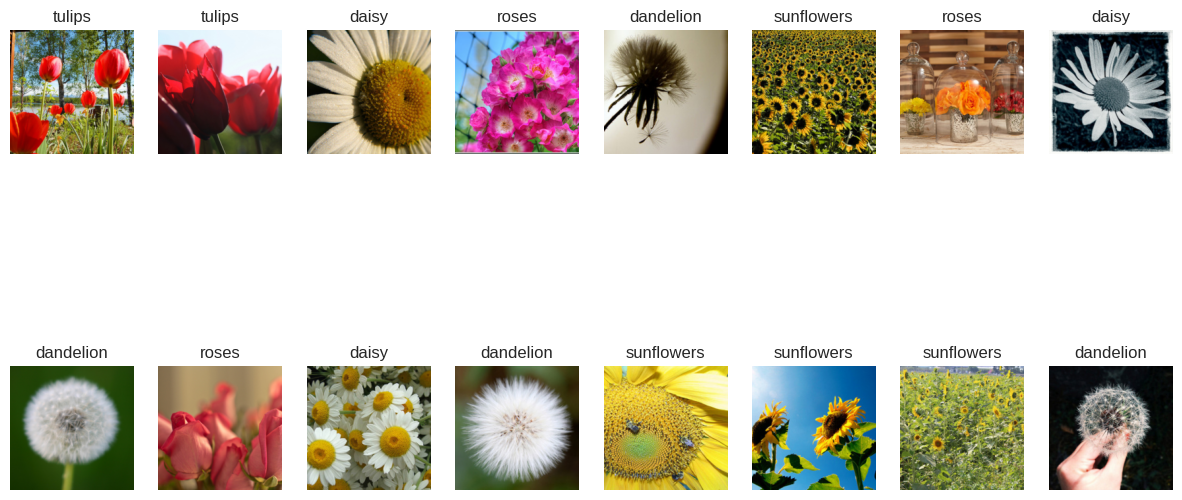

In [ ]:
# images, labels =next(iter(train_dataloader))

# #print (images.shape, labels.shape)

# fig = plt.figure(figsize=(15,8))

# for i in range (BATCH_SIZE):

#     ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)

#     fn_showImages(images[i], ax)

#     ax.set_title(class_names[labels[i].item()])

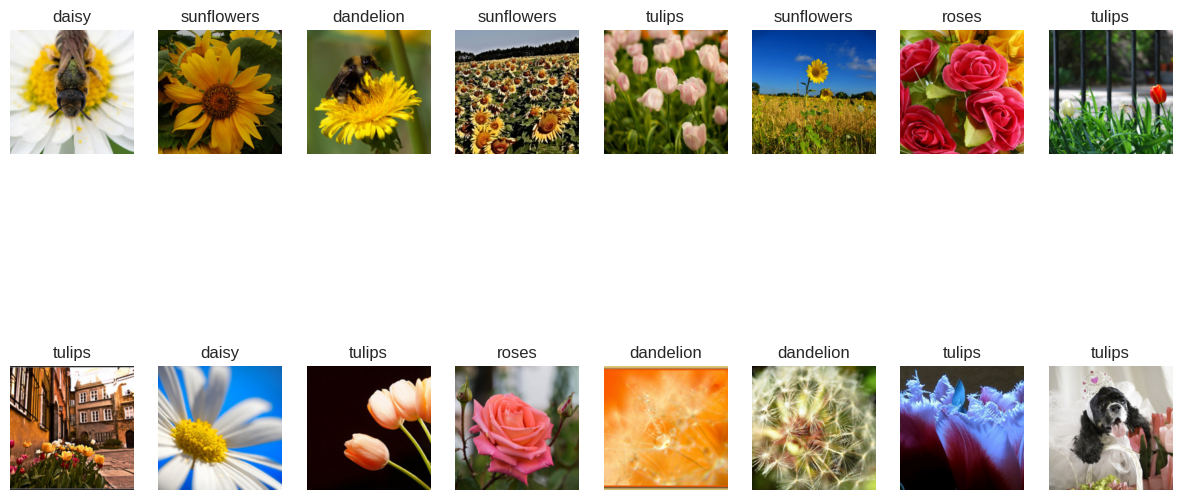

In [ ]:
# images, labels =next(iter(test_dataloader))

# #print (images.shape, labels.shape)

# fig = plt.figure(faigsize=(15,8))

# for i in range (BATCH_SIZE):

#     ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)

#     fn_showImages(images[i], ax)

#     ax.set_title(class_names[labels[i].item()])

In [ ]:
class LeNet(nn.Module):
  def __init__(self,numChannels, classes):
    # call the parent constructor
    super(LeNet, self).__init__()
    #dropouts
    dor1 = 0.3
    dor2 = 0.3
    dor3 = 0.4
    dor4 = 0.5
    dor5 = 0.5
    # define layers
    ##set1
    out_channels1 = 32
    #conv->BN->LeakyRelu->Pool->dropout
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=out_channels1, kernel_size=(3,3))# output_shape= 184,184,128
    self.bn1 = nn.BatchNorm2d(out_channels1)
    self.actv1 = nn.LeakyReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=(4,4), stride=(4,4))#output_shape= 46,46,128
    self.dropout1 = nn.Dropout(p=dor1)

    #set2
    out_channels2 = 64
    #conv->BN->LeakyRelu->Pool->dropout
    self.conv2 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, kernel_size=(3,3))
    self.bn2 = nn.BatchNorm2d(out_channels2)
    self.actv2 = nn.LeakyReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.dropout2 = nn.Dropout(p=dor2)

    #set3
    out_channels3 = 128
    #conv->BN->LeakyRelu->Pool->dropout
    self.conv3 = nn.Conv2d(in_channels=out_channels2, out_channels=out_channels3, kernel_size=(3,3))
    self.bn3 = nn.BatchNorm2d(out_channels3)
    self.actv3 = nn.LeakyReLU()
    self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.dropout3 = nn.Dropout(p=dor3)

    #set4
    out_channels4 = 256
    #conv->BN->LeakyRelu->Pool->dropout
    self.conv4 = nn.Conv2d(in_channels=out_channels3, out_channels=out_channels4, kernel_size=(3,3))
    self.bn4 = nn.BatchNorm2d(out_channels4)
    self.actv4 = nn.LeakyReLU()
    self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.dropout4 = nn.Dropout(p=dor4)

    # head

    out_channels5=1024
    # linear ->BN ->LeakyRelu->Pool ->dropout
    self.fc1 = nn.Linear(in_features=out_channels4*4*4, out_features=out_channels5)
    self.bn5 = nn.BatchNorm1d(out_channels5)
    self.actv5 = nn.LeakyReLU()
    self.dropout5 = nn.Dropout(p=dor5)

    self.fc2 = nn.Linear(in_features=out_channels5, out_features=classes)

    self.logsoftmax = nn.LogSoftmax(dim=1)


  def forward(self, x):
    # pass through 1
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.actv1(x)
    x = self.maxpool1(x)
    x = self.dropout1(x)

    # pass through 2
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.actv2(x)
    x = self.maxpool2(x)
    x = self.dropout2(x)

    # pass through 3
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.actv3(x)
    x = self.maxpool3(x)
    x = self.dropout3(x)

    # pass through 4
    x = self.conv4(x)
    x = self.bn4(x)
    x = self.actv4(x)
    x = self.maxpool4(x)
    x = self.dropout4(x)

    # flatten
    x = torch.flatten(x, 1)

    # head fully connected layers
    x = self.fc1(x)
    x = self.bn5(x)
    x = self.actv5(x)
    x = self.dropout5(x)

    #output
    x = self.fc2(x)

    return self.logsoftmax(x)

In [ ]:
numChannels = 3
model = LeNet(numChannels=numChannels, classes=numClasses).to(device)
summary(model, (numChannels, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 186, 186]             896
       BatchNorm2d-2         [-1, 32, 186, 186]              64
         LeakyReLU-3         [-1, 32, 186, 186]               0
         MaxPool2d-4           [-1, 32, 46, 46]               0
           Dropout-5           [-1, 32, 46, 46]               0
            Conv2d-6           [-1, 64, 44, 44]          18,496
       BatchNorm2d-7           [-1, 64, 44, 44]             128
         LeakyReLU-8           [-1, 64, 44, 44]               0
         MaxPool2d-9           [-1, 64, 22, 22]               0
          Dropout-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
      BatchNorm2d-12          [-1, 128, 20, 20]             256
        LeakyReLU-13          [-1, 128, 20, 20]               0
        MaxPool2d-14          [-1, 128,

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)

loss_fn = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_FACTOR, patience=LR_PATIENCE, min_lr=1e-5)

H={
    'Epoch' : [],
    'Train Loss' : [],
    'Train Acc' : [],
    'Test Loss' : [],
    'Test Acc' : [],
    'Alpha' :[],
    'Patience' : [],
  }
print('done')


done


In [ ]:
minLoss = float('inf')
savepath ='/content/drive/MyDrive/Colab_Notebooks/flower/torch_flower/torch_flower.pt'

for epoch in range(EPOCHS):
  epochStart = time.time()
  train_loss= 0.0
  train_acc = 0.0
  for i,data in enumerate(train_dataloader):
    model.train()
    inputs,labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    preds = torch.argmax(outputs, dim=1)
    batch_loss = loss_fn(outputs, labels)
    batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    batch_loss.backward()
    optimizer.step()

    train_loss += batch_loss.item()*inputs.size(0)
    train_acc += batch_acc.item()*inputs.size(0)

  train_loss = train_loss/len(train_dataset)
  train_acc = train_acc/len(train_dataset)

  H['Train Loss'].append(train_loss)
  H['Train Acc'].append(train_acc)

  test_loss= 0.0
  test_acc = 0.0

  with torch.no_grad():
    model.eval()
    for data in test_dataloader:
      inputs,labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      preds = torch.argmax(outputs, dim=1)

      batch_loss = loss_fn(outputs, labels)
      batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

      test_loss += batch_loss.item()*inputs.size(0)
      test_acc += batch_acc.item()*inputs.size(0)

  test_loss = test_loss/len(test_dataset)
  test_acc = test_acc/len(test_dataset)

  H['Test Loss'].append(test_loss)
  H['Test Acc'].append(test_acc)
  H['Epoch'].append(epoch)

  lr_scheduler.step(test_loss)

  if test_loss < minLoss:
    minLoss = test_loss
    counter = 0

    torch.save({'epoch': epoch+1,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict,
                'loss':loss_fn,}, savepath)
  else:
    counter += 1

  if counter > PATIENCE:
    break

  curr_alpha = lr_scheduler.get_last_lr()[0]
  H['Alpha'].append(curr_alpha)
  H['Patience'].append(counter)

  if epoch % 10 == 0:
    print(f'Epoch:{epoch:3d}/{EPOCHS:3d}',end=' ')
    print(f'Loss:{train_loss:.6f}/{test_loss:.6f}, Accuracy: {train_acc:.4f}/{test_acc:.4f}',end=' ')
    print(f'Alpha:{curr_alpha:.6f}, ES:{counter:2d}',end=' ')
    print(f'Epoch time:{time.time()-epochStart:.2f}Sec')

RuntimeError: Parent directory /content/drive/MyDrive/Colab_Notebooks/flower/torch_flower does not exist.

In [ ]:
train_transform = v2.Compose([
    v2.Resize(IMG_HEIGHT),
    v2.RandomRotation(degrees=(-45,45)),
    v2.CenterCrop(IMG_HEIGHT),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = v2.compose([
    v2.Resize(IMG_HEIGHT),
    v2.CenterCrop(IMG_HEIGHT),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize( mean = [0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(data_dir, transform=transform)

train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(data_dir, transform=test_transform)

In [ ]:
image, label = next(iter(train_dataset))
image.shape, label

In [ ]:
dataset_size = len(dataset)

indices = torch.randperm(dataset_size).tolist()

train_dataset = torch.utils.data.Subset(train_dataset,indices[:TRAIN_SIZE])
test_dataset = torch.utils.data.Subset(test_dataset,indices[TRAIN_SIZE:])
len(train_dataset), len(test_dataset)